In [ ]:
#| default_exp models.mlp

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MLP
> One of the simplest neural architectures are Multi Layer Perceptrons (`MLP`) composed of stacked Fully Connected Neural Networks trained with backpropagation. Each node in the architecture is capable of modeling non-linear relationships granted by their activation functions. Novel activations like Rectified Linear Units (`ReLU`) have greatly improved the ability to fit deeper networks overcoming gradient vanishing problems that were associated with `Sigmoid` and `TanH` activations. For the forecasting task the last layer is changed to follow a auto-regression problem.<br><br>**References**<br>-[Rosenblatt, F. (1958). "The perceptron: A probabilistic model for information storage and organization in the brain."](https://psycnet.apa.org/record/1959-09865-001)<br>-[Fukushima, K. (1975). "Cognitron: A self-organizing multilayered neural network."](https://pascal-francis.inist.fr/vibad/index.php?action=getRecordDetail&idt=PASCAL7750396723)<br>-[Vinod Nair, Geoffrey E. Hinton (2010). "Rectified Linear Units Improve Restricted Boltzmann Machines"](https://www.cs.toronto.edu/~fritz/absps/reluICML.pdf)<br>

![Figure 1. Three layer MLP with autorregresive inputs.](imgs_models/mlp.png)

In [ ]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

In [ ]:
#| exporti
from typing import Optional, Callable

import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows
from neuralforecast.common._modules import RevIN

In [ ]:
#| export     

class GLU_FFN(nn.Module):
    def __init__(self, d_hidden: int, d_ff: int, dropout: float = 0.1, activation: Callable = F.relu, bias: bool = True) -> None:
        super().__init__()

        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_hidden, d_ff, bias=bias)
        self.linear1g = nn.Linear(d_hidden, d_ff, bias=bias)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_hidden, bias=bias)
        self.activation = activation

    def forward(self, x: Tensor) -> Tensor:
        x1 = self.dropout1(self.linear1(x))
        x2 = self.linear1g(x)
        hidden = self.activation(x1) * x2
        return self.dropout2(self.linear2(hidden))

class PatchMixLayer(nn.Module):
    def __init__(self, d_hidden: int, n_patches: int, d_ff: int, dropout: float = 0.1, activation: Callable = F.relu, bias: bool = True) -> None:
        super().__init__()

        # Patch FFN
        self.patch_ffn = GLU_FFN(d_hidden, d_ff, dropout, activation, bias)
        self.norm1 = nn.BatchNorm1d(n_patches)

        # Feature ffn
        self.feature_ffn = GLU_FFN(n_patches, d_ff, dropout, activation, bias)
        self.norm2 = nn.BatchNorm1d(d_hidden)

    def forward(self, x: Tensor) -> Tensor:                # [B, n_patches, hidden_size]
        
        x = self.norm1(x + self.patch_ffn(x))

        x = x.permute(0, 2, 1)
        x = self.norm2(x + self.feature_ffn(x))
        x = x.permute(0, 2, 1)

        return x    

In [ ]:
#| export
class MLP(BaseWindows):
    """ MLP

    Modified MLP

    **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
    `hidden_size`: int=16, units for the hidden state size.<br>
    `dropout`: float=0.1, dropout rate used for the dropout layers throughout the architecture.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
    `windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
    `lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>
    `dataloader_kwargs`: dict, optional, list of parameters passed into the PyTorch Lightning dataloader by the `TimeSeriesDataLoader`. <br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

    **References**<br>  

    """
    # Class attributes
    SAMPLING_TYPE = 'windows'
    EXOGENOUS_FUTR = False
    EXOGENOUS_HIST = False
    EXOGENOUS_STAT = False

    def __init__(
                self,
                h: int,
                input_size: int,
                encoder_layers: int = 3,
                hidden_size: int = 128,
                linear_hidden_size: int = 256,
                dropout: float = 0.2,
                patch_len: int = 16,
                stride: int = 8,
                revin: bool = True,
                linear_bias: bool = True,
                activation: Callable = F.gelu,
                futr_exog_list=None,
                hist_exog_list=None,
                stat_exog_list=None,
                exclude_insample_y=False,
                loss=MAE(),
                valid_loss=None,
                max_steps: int = 5000,
                learning_rate: float = 1e-4,
                num_lr_decays: int = -1,
                early_stop_patience_steps: int = -1,
                val_check_steps: int = 100,
                batch_size: int = 32,
                valid_batch_size: Optional[int] = None,
                windows_batch_size=1024,
                inference_windows_batch_size=1024,
                start_padding_enabled=False,
                step_size: int = 1,
                scaler_type: str = "identity",
                random_seed: int = 1,
                drop_last_loader: bool = False,
                optimizer=None,
                optimizer_kwargs=None,
                lr_scheduler=None,
                lr_scheduler_kwargs=None,
                dataloader_kwargs=None,
                **trainer_kwargs
            ):
        super(MLP, self).__init__(
            h=h,
            input_size=input_size,
            futr_exog_list=futr_exog_list,
            hist_exog_list=hist_exog_list,
            stat_exog_list=stat_exog_list,
            exclude_insample_y = exclude_insample_y,
            loss=loss,
            valid_loss=valid_loss,
            max_steps=max_steps,
            learning_rate=learning_rate,
            num_lr_decays=num_lr_decays,
            early_stop_patience_steps=early_stop_patience_steps,
            val_check_steps=val_check_steps,
            batch_size=batch_size,
            valid_batch_size=valid_batch_size,
            windows_batch_size=windows_batch_size,
            inference_windows_batch_size=inference_windows_batch_size,
            start_padding_enabled=start_padding_enabled,
            step_size=step_size,
            scaler_type=scaler_type,
            random_seed=random_seed,
            drop_last_loader=drop_last_loader,
            optimizer=optimizer,
            optimizer_kwargs=optimizer_kwargs,
            lr_scheduler=lr_scheduler,
            lr_scheduler_kwargs=lr_scheduler_kwargs,
            dataloader_kwargs=dataloader_kwargs,
            **trainer_kwargs
        )

        #----------------------------------- Parse dimensions -----------------------------------#
        self.h = h
        self.input_size = input_size

        # RevIN
        self.revin = revin
        if self.revin:
          self.revin_layer = RevIN(1, affine=False, subtract_last=True)

        # Patches
        n_patches = int((input_size - patch_len) / stride + 1)
        self.padding_patch_layer = nn.ReplicationPad1d((0, stride))
        n_patches += 1
        self.patch_len = min(input_size + stride, patch_len)
        self.stride = stride

        # Linear projection
        self.linear_projection = nn.Linear(patch_len, hidden_size)       
        self.dropout = nn.Dropout(dropout)
      
        # Patchmixer
        patchmix_layers = [PatchMixLayer(hidden_size, n_patches, linear_hidden_size, dropout, activation, linear_bias) for _ in range(encoder_layers)]
        self.patchmixer = nn.Sequential(*patchmix_layers)

        # Decoder
        self.linear_decoder = nn.Sequential(
            nn.Flatten(start_dim=-2),
            nn.Linear(n_patches * hidden_size, h * self.loss.outputsize_multiplier),
        )            

    def forward(self, windows_batch):
        # Parse windows_batch
        x    = windows_batch['insample_y']                          #   [B, L] 
        batch_size = x.size(0)

        # RevIN
        if self.revin:
            x = self.revin_layer(x.unsqueeze(-1), mode="norm")      #   [B, L] -> [B, L, 1]
            x = x.squeeze(-1)                                       #   [B, L, 1] -> [B, L]

        # Padding
        x = self.padding_patch_layer(x.unsqueeze(1))                #   [B, 1, L] -> [B, 1, L + stride]
        x = x.squeeze(1)                                            #   [B, 1, L + stride] -> [B, L + stride]

        # Unfold patches
        x = x.unfold(-1, self.patch_len, self.stride)               #   [B, L] -> [B, n_patches, patch_len]

        # Linear projection
        x = self.dropout(self.linear_projection(x))                 #   [B, n_patches, patch_len] -> [B, n_patches, hidden_size]
        
        # Encoder
        x = self.patchmixer(x)                                      #   [B, n_patches, hidden_size] -> [B, n_patches, hidden_size]        

        # Decoder
        x = self.linear_decoder(x)                                  #   [B, n_patches, hidden_size] -> [B, h * n_outputs]       
        x = x.reshape(batch_size, self.h, -1)                       #   [B, h * n_outputs] -> [B, h, n_outputs]

        # RevIN
        if self.revin:
            x = self.revin_layer(x, mode="denorm")

        # Map to output domain
        forecast = self.loss.domain_map(x)
        
        return forecast

In [ ]:
show_doc(MLP)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/mlp.py#L218){target="_blank" style="float:right; font-size:smaller"}

### MLP

>      MLP (h:int, input_size:int, encoder_layers:int=3, hidden_size:int=128,
>           linear_hidden_size:int=256, dropout:float=0.2, patch_len:int=16,
>           stride:int=8, revin:bool=True, linear_bias:bool=True,
>           activation:Callable=<built-in function gelu>, futr_exog_list=None,
>           hist_exog_list=None, stat_exog_list=None, exclude_insample_y=False,
>           loss=MAE(), valid_loss=None, max_steps:int=5000,
>           learning_rate:float=0.0001, num_lr_decays:int=-1,
>           early_stop_patience_steps:int=-1, val_check_steps:int=100,
>           batch_size:int=32, valid_batch_size:Optional[int]=None,
>           windows_batch_size=1024, inference_windows_batch_size=1024,
>           start_padding_enabled=False, step_size:int=1,
>           scaler_type:str='identity', random_seed:int=1,
>           drop_last_loader:bool=False, optimizer=None, optimizer_kwargs=None,
>           lr_scheduler=None, lr_scheduler_kwargs=None, dataloader_kwargs=None,
>           **trainer_kwargs)

*MLP

Modified MLP

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
`hidden_size`: int=16, units for the hidden state size.<br>
`dropout`: float=0.1, dropout rate used for the dropout layers throughout the architecture.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of different series in each batch.<br>
`valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
`windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
`inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
`start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
`optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
`lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
`lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>
`dataloader_kwargs`: dict, optional, list of parameters passed into the PyTorch Lightning dataloader by the `TimeSeriesDataLoader`. <br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

**References**<br>*

In [ ]:
show_doc(MLP.fit, name='MLP.fit')

---

### MLP.fit

>      MLP.fit (dataset, val_size=0, test_size=0, random_seed=None,
>               distributed_config=None)

*Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`test_size`: int, test size for temporal cross-validation.<br>*

In [ ]:
show_doc(MLP.predict, name='MLP.predict')

---

### MLP.predict

>      MLP.predict (dataset, test_size=None, step_size=1, random_seed=None,
>                   **data_module_kwargs)

*Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).*

In [ ]:
#| hide
import logging
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast.utils import AirPassengersDF as Y_df
from neuralforecast.tsdataset import TimeSeriesDataset

## Usage Example

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | loss                | MAE              | 0      | train
1 | padder_train        | ConstantPad1d    | 0      | train
2 | scaler              | TemporalNorm     | 0      | train
3 | revin_layer         | RevIN            | 0      | train
4 | padding_patch_layer | ReplicationPad1d | 0      | train
5 | linear_projection   | Linear           | 2.2 K  | train
6 | dropout             | Dropout          | 0      | train
7 | patchmixer          | Sequential       | 306 K  | train
8 | linear_decoder      | Sequential       | 4.6 K  | train
-----------------------------------------------------------------
312 K     Trainable params
0         Non-trainable params
312 K     Total params
1.251     Tota

Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 20.94it/s, v_num=11669, train_loss_step=0.439, train_loss_epoch=0.439, valid_loss=35.00]


c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.22it/s]


[]

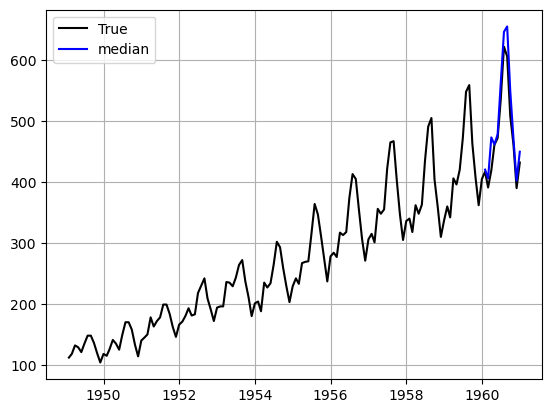

In [ ]:
#| eval: false
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
# from neuralforecast.models import MLP
from neuralforecast.losses.pytorch import DistributionLoss, GMM
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = MLP(h=12, 
            input_size=24,
            # loss=GMM(n_components=7, return_params=True, level=[80,90]),
            # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
            scaler_type="robust",
            max_steps=1000,
            early_stop_patience_steps=3,
            revin=True,
            )

fcst = NeuralForecast(
    models=[model],
    freq='M'
)
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['MLP'], c='blue', label='median')
# plt.fill_between(x=plot_df['ds'][-12:], 
                #  y1=plot_df['MLP-lo-90'][-12:].values, 
                #  y2=plot_df['MLP-hi-90'][-12:].values,
                #  alpha=0.4, label='level 90')
# plt.plot(plot_df['ds'], plot_df['MLP-median'], c='blue', label='median')
# plt.fill_between(x=plot_df['ds'][-12:], 
#                  y1=plot_df['MLP-lo-90'][-12:].values, 
#                  y2=plot_df['MLP-hi-90'][-12:].values,
#                  alpha=0.4, label='level 90')
plt.grid()
plt.legend()
plt.plot()